In [1]:
# import the required libraries

import torch
from torch import nn

torch.__version__

'2.1.2+cu118'

In [2]:
# setup the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# get and download the dataset
# we're going to use subsets of Food101 dataset

import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists ...")
else:
    print(f"{image_path} doesn't exist, creating one ...")
    image_path.mkdir(parents=True, exist_ok=True)


# download the dataset
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading the dataset ...")
    f.write(request.content)


# unzip the downloaded datadet
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unziping the dataset ...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists ...
Unziping the dataset ...


In [4]:
# data preparation and exploration
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returing it's content

    Args:
        dir_path (str): _description_
    """
    
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'


In [7]:
# setup the train and test path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Path: data\pizza_steak_sushi\train\sushi\307738.jpg
Image class: sushi
Image height: 382
Image width: 512


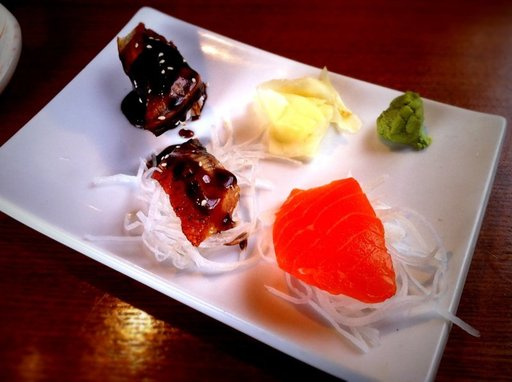

In [8]:
# visualizing an image
import random
from PIL import Image

# get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# select a random image path
random_image_path = random.choice(image_path_list)
print(f"Path: {random_image_path}")

# get the image class
image_class = random_image_path.parent.stem
print(f"Image class: {image_class}")

# open the image
img = Image.open(random_image_path)
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

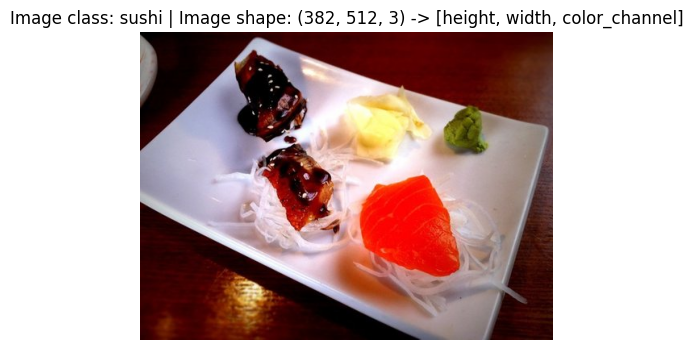

In [9]:
# try to visualize the image using matplotlib
import numpy as np
import matplotlib.pyplot as plt

# convert the image to numpy array
image_array = np.asarray(img)

# let's visualize the image
plt.figure(figsize=(6, 4))
plt.imshow(image_array)
plt.title(f"Image class: {image_class} | Image shape: {image_array.shape} -> [height, width, color_channel]")
plt.axis(False)
plt.show()

In [39]:
# image_array

#### Transforming data

In [10]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [11]:
# data augmentation
# create a train transformation

train_transform = transforms.Compose([
    # resize the image to 224X224
    transforms.Resize(size=(224, 224)),
    
    # flip the image randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    
    transforms.RandomRotation(10),
    # #transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    # # transforms.ColorJitter(brightness=0.1, contrast=0.1),
    
    # turn the image into torch.Tensor
    transforms.ToTensor()
])


test_transform = transforms.Compose([
    # resize the image to 224X224
    transforms.Resize(size=(224, 224)),
    
    # turn the image into torch.Tensor
    transforms.ToTensor()
])

In [12]:
train_transform(img)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [13]:
train_transform(img).shape

torch.Size([3, 224, 224])

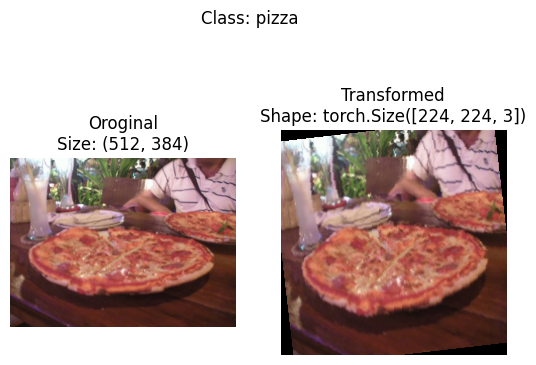

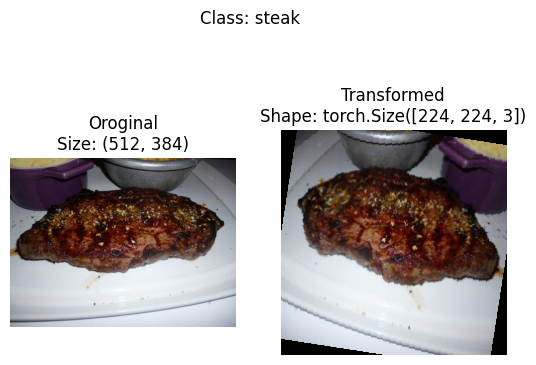

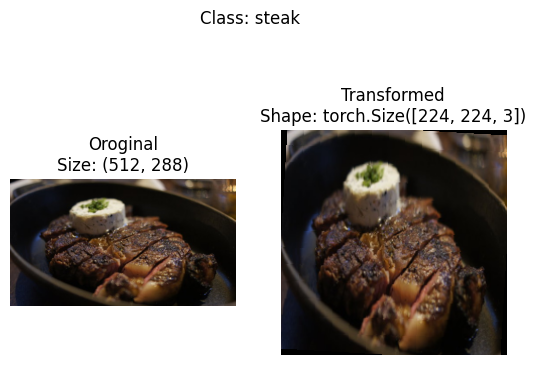

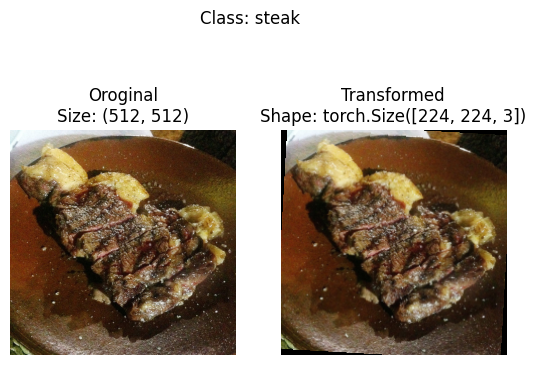

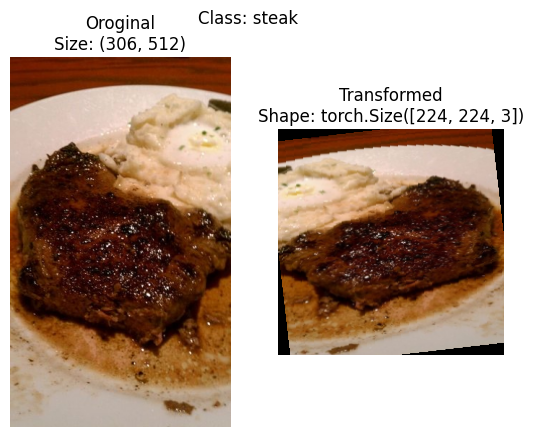

In [14]:

def plot_transformed_images(image_paths: list, transform: torchvision.transforms, n=3, seed=None):
    
    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, k=n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            
            ax[0].imshow(f)
            ax[0].set_title(f"Oroginal\nSize: {f.size}")
            ax[0].axis(False)
            
            # transform and plot the image
            transformed_image = transform(f).permute(1, 2, 0)   # from [C, H, W] -> [H, W, C]
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=12)

plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=5,
                        seed=None)

##### Option1: Loading image data using `ImageFolder`

In [15]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform,
    target_transform=None
)

In [16]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

In [17]:
test_data

Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [18]:
# get the class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
# get the classes as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
len(train_data), len(test_data)

(225, 75)

In [21]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [22]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Shape of the image: {img.shape}")
print(f"Data type of the tensor: {img.dtype}")
print(f"Label of image: {label}")
print(f"Data type of the label: {type(label)}")

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Shape of the image: torch.Size([3, 224, 224])
Data type of the tensor: torch.float32
Label of image: 0
Data type of the label: <class 'int'>


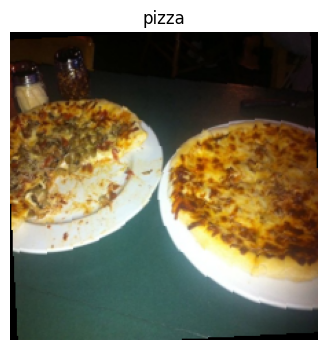

In [23]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0) # from [C, H, W] to [H, W, C]

# visualize the image
plt.figure(figsize=(6, 4))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=12)
plt.show()

#### Turn the `Dataset` into `DataLoader`'s
A `DataLoader` is going to help us to turn our `Dataset` into iterable. We can customize the `batch size`, so our model can see `batch size` images at a time.

In [24]:
import os
os.cpu_count()

12

In [33]:
# turn our train and test datasets into DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE = 4

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    #num_workers=1,
    shuffle=False
)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x155fdc0fe90>,
 <torch.utils.data.dataloader.DataLoader at 0x155fdc01090>)

In [34]:
len(train_dataloader), len(test_dataloader)

(57, 19)

In [35]:
images, labels = next(iter(train_dataloader))
images.shape # [batch_size, C, H, W]

torch.Size([4, 3, 224, 224])

In [28]:
type(labels)

torch.Tensor

In [29]:
labels.shape 

torch.Size([4])

In [36]:

class FoodModel(nn.Module):
    
    def __init__(self, input_channels, output_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.block_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Optional additional block for increased feature extraction depth
        self.block_4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # # Adaptive pooling to handle variability in image size and create a fixed-size output
        #self.pool = nn.AdaptiveMaxPool2d((8, 8))
        
        self.fully_conn_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*14*14, 1024),
            nn.ReLU(),
            nn.Dropout(0.33),
            nn.Linear(1024, output_shape)
            # nn.ReLU(),
            # nn.Dropout(0.4),
            # nn.Linear(1024, 256),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            # nn.Linear(256, output_shape)
        )
    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        #x = self.pool(x)
        x = self.fully_conn_block(x)
        return x

In [37]:
model_2 = FoodModel(
    input_channels=3,
    output_shape=len(class_names)
).to(device)

In [38]:
from torchsummary import summary

summary(model_2, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

In [39]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [40]:

def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                train_loss_accum: list,
                train_acc_accum: list,
                device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logit = model(X)
        
        y_proba = torch.softmax(y_logit, dim=1)
        y_pred = y_proba.argmax(dim=1)

        # 2. Calculate loss
        loss = loss_fn(y_logit, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_loss_accum.append(train_loss.item())
    train_acc_accum.append(train_acc/100.0)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
    

def test_step(data_loader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                test_loss_accum: list,
                test_acc_accum: list,
                device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    model.to(device)
    
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_logit = model(X)
            test_proba = torch.softmax(test_logit, dim=1)
            test_pred = test_proba.argmax(dim=1)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_logit, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_loss_accum.append(test_loss.item())
        test_acc_accum.append(test_acc/100.0)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [41]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    
    return total_time

In [42]:
from tqdm.auto import tqdm # type: ignore

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

model_2 = FoodModel(
    input_channels=3,
    output_shape=len(class_names)
).to(device)

# Train and test model 
epochs = 20

# list to store train and test loss, accuracy
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                        betas=(0.9, 0.999),
                        lr=0.0001)

# optimizer = torch.optim.SGD(params=model_0.parameters(),
#                         lr=0.1)

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        train_loss_accum=train_losses,
        train_acc_accum=train_accuracies,
        device=device
    )
    
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        test_loss_accum=test_losses,
        test_acc_accum=test_accuracies,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                        end=train_time_end_model_2,
                                        device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.39545 | Train accuracy: 42.54%
Test loss: 1.56050 | Test accuracy: 47.37%

Epoch: 1
---------
Train loss: 1.00025 | Train accuracy: 59.21%
Test loss: 1.07405 | Test accuracy: 43.42%

Epoch: 2
---------
Train loss: 0.82872 | Train accuracy: 62.72%
Test loss: 0.97196 | Test accuracy: 46.05%

Epoch: 3
---------
Train loss: 0.76446 | Train accuracy: 67.11%
Test loss: 0.90567 | Test accuracy: 55.70%

Epoch: 4
---------
Train loss: 0.65921 | Train accuracy: 71.49%
Test loss: 1.13865 | Test accuracy: 53.51%

Epoch: 5
---------
Train loss: 0.63249 | Train accuracy: 75.44%
Test loss: 1.19006 | Test accuracy: 61.40%

Epoch: 6
---------
Train loss: 0.51558 | Train accuracy: 77.63%
Test loss: 0.96683 | Test accuracy: 59.65%

Epoch: 7
---------
Train loss: 0.54724 | Train accuracy: 79.82%
Test loss: 1.09471 | Test accuracy: 56.14%

Epoch: 8
---------
Train loss: 0.52140 | Train accuracy: 78.95%
Test loss: 1.03164 | Test accuracy: 58.33%

Epoch: 9
---------
Train los

In [43]:
def plot_training_history(epochs, train_losses, train_accuracies, test_losses, test_accuracies):
    # Plot training metrics
    plt.figure(figsize=(12, 7))
    
    # Subplot for training and testing loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1, epochs + 1))  # Ensures integer values on the x-axis
    
    # Subplot for training and testing accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1, epochs + 1))  # Ensures integer values on the x-axis
    
    plt.tight_layout()
    plt.show()

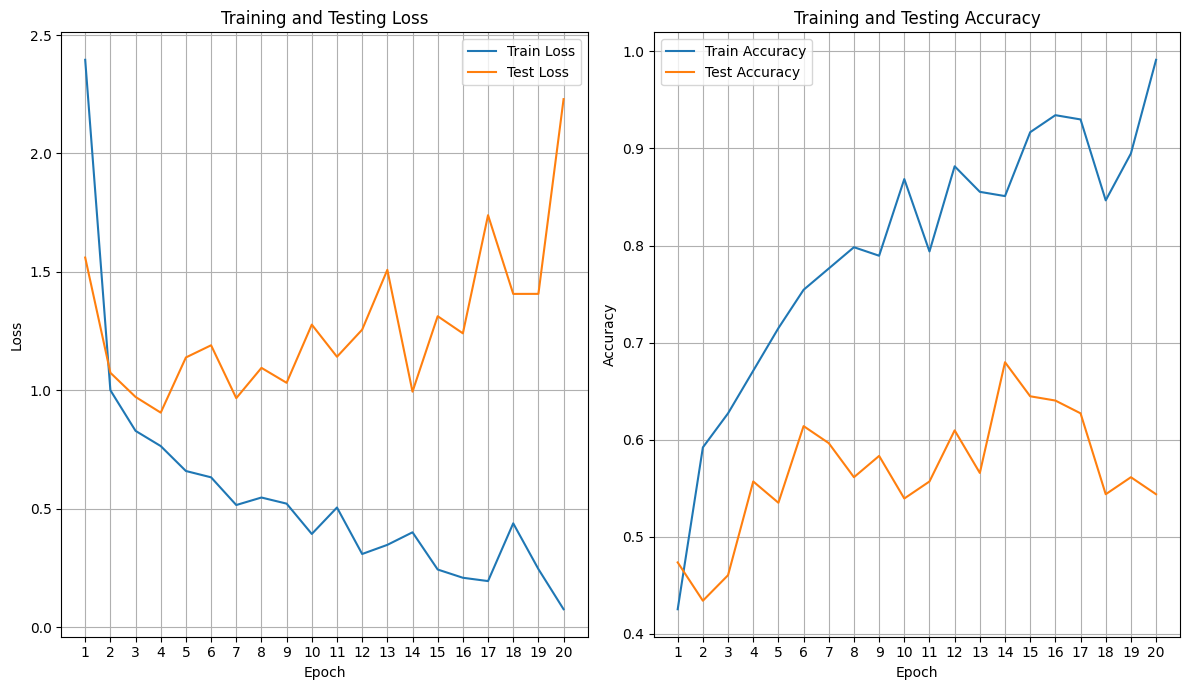

In [44]:
plot_training_history(
    epochs=epochs,
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

In [40]:
# model_1.state_dict()

In [41]:
# saving a model in PyTorch
from pathlib import Path

In [42]:
# model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = "model_1_food.pth"

# create model save path
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

WindowsPath('models/model_1_food.pth')

In [43]:
# save the model state_dict()
print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(model_1.state_dict(), 
            f=MODEL_SAVE_PATH)

saving model to: models\model_1_food.pth
